This notebook uses LDA to extract topics from the curriculum texts and uses pyLDAvis for visualization.

LDA considers each document as a collection of topics in a certain proportion. It rearranges the topics distribution within the documents and keywords distribution within the topics to obtain a good composition of topic-keywords distribution.


### Import Libraries and Data

In [16]:
import pandas as pd
import numpy as np
import spacy
nlp = spacy.load('en_core_web_lg')

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
from pprint import pprint

In [17]:
df = pd.read_csv('text-similarity-2.csv', index_col=0)

In [18]:
df['text_parsed'] = list(nlp.pipe(df['text']))

In [19]:
# remove stopwords and punctuations
df['tokenized'] = df['text_parsed'].apply(lambda doc: [str(t) for t in doc if not t.is_punct and not t.is_stop])

In [20]:
# with nouns
df['text_nouns'] = df['text_parsed'].apply(lambda doc: nlp(" ".join([str(t) for t in doc if t.pos_ in ['NOUN', 'PROPN']])))

In [21]:
data_words = list(df['tokenized'])

In [22]:
data_nouns = list(df['text_nouns'])

### Create bigrams and trigram models

In [23]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(df['tokenized'], min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df['tokenized']], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[df['tokenized'][0]]])

['Practise', 'refine', 'technical', 'expressive', 'skills', 'develop', 'proficiency', 'genre', 'style', 'specific', 'techniques']


### Remove Stopwords, Make Bigrams and Lemmatize

In [24]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [25]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['practise', 'refine', 'technical', 'expressive', 'skill', 'develop', 'proficiency', 'genre', 'style', 'specific', 'technique']]


### Create the Dictionary and Corpus needed for Topic Modeling

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

In [26]:
# The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus.
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]]


In [27]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('develop', 1),
  ('expressive', 1),
  ('genre', 1),
  ('practise', 1),
  ('proficiency', 1),
  ('refine', 1),
  ('skill', 1),
  ('specific', 1),
  ('style', 1),
  ('technical', 1),
  ('technique', 1)]]

### Building the Topic Model

alpha affects sparsity of the topics. According to the Gensim docs, defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. 
update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [28]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=50,
                                           passes=10,
                                           alpha='asymmetric',
                                           per_word_topics=True)

In [29]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.029*"different" + 0.027*"evaluate" + 0.027*"text" + 0.025*"range" + '
  '0.019*"context" + 0.018*"explore" + 0.018*"design" + 0.017*"develop" + '
  '0.016*"structure" + 0.015*"create"'),
 (1,
  '0.063*"system" + 0.019*"perspective" + 0.017*"operation" + 0.016*"health" + '
  '0.016*"apply" + 0.015*"compare" + 0.015*"rely" + 0.015*"universe" + '
  '0.015*"magnet" + 0.015*"coordinate"'),
 (2,
  '0.050*"explain" + 0.050*"include" + 0.035*"influence" + 0.024*"people" + '
  '0.024*"global" + 0.024*"different" + 0.023*"government" + 0.022*"response" '
  '+ 0.022*"society" + 0.022*"value"'),
 (3,
  '0.026*"scientific" + 0.024*"technology" + 0.024*"information" + '
  '0.023*"chemical" + 0.019*"appropriate" + 0.019*"include" + 0.018*"datum" + '
  '0.018*"environment" + 0.016*"time" + 0.015*"connect"'),
 (4,
  '0.056*"place" + 0.032*"cause" + 0.027*"simple" + 0.026*"living" + '
  '0.020*"nature" + 0.019*"contribute" + 0.018*"link" + 0.017*"consequence" + '
  '0.017*"predict" + 0.014*"co

### Compute Model Perplexity and Coherence Score

Perplexity metric measures how probable some new unseen data is given the model that was learned earlier. That is to say, how well does the model represent or reproduce the statistics of the held-out data.

Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.

In [30]:
# Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.015899725880804

Coherence Score:  0.4622975898245669


### Visualize the topics-keywords
Examine the produced topics and the associated keywords. 

Each bubble represents a topic. The larger the bubble, the more prevalent is that topic. A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

In [31]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.194507 -0.182233       1        1  31.291172
2      0.206549  0.130030       2        1  16.062241
6     -0.129540 -0.174960       3        1  11.109235
4     -0.072913  0.010990       4        1   9.039829
5      0.006775  0.059208       5        1   8.621739
3     -0.053619 -0.042959       6        1   8.521198
1     -0.142022  0.106081       7        1   8.354706
7     -0.009737  0.093842       8        1   6.999884, topic_info=    Category       Freq           Term      Total  loglift  logprob
210  Default  25.000000        explain  25.000000  30.0000  30.0000
214  Default  17.000000         system  17.000000  29.0000  29.0000
436  Default  16.000000          place  16.000000  28.0000  28.0000
344  Default  17.000000        involve  17.000000  27.0000  27.0000
44   Default  43.000000        include  43.000000  26.0000  26.0000
35   Default  39.000000       evaluate  39.000000  25.0000  25.0000
86   Default  13.000000         effect  13.000000  24.0000  24.0000
179  Default  21.000000      influence  21.000000  23.0000  23.0000
119  Default  41.000000      different  41.000000  22.0000  22.0000
207  Default   9.000000          event   9.000000  21.0000  21.0000
96   Default  27.000000           text  27.000000  20.0000  20.0000
445  Default  21.000000         change  21.000000  19.0000  19.0000
564  Default  10.000000    significant  10.000000  18.0000  18.0000
847  Default  13.000000     scientific  13.000000  17.0000  17.0000
625  Default   9.000000    development   9.000000  16.0000  16.0000
439  Default   9.000000          cause   9.000000  15.0000  15.0000
49   Default  19.000000         people  19.000000  14.0000  14.0000
190  Default  12.000000         global  12.000000  13.0000  13.0000
212  Default  12.000000     government  12.000000  12.0000  12.0000
175  Default  11.000000       response  11.000000  11.0000  11.0000
395  Default   9.000000   relationship   9.000000  10.0000  10.0000
384  Default   8.000000         simple   8.000000   9.0000   9.0000
325  Default   9.000000         energy   9.000000   8.0000   8.0000
194  Default  11.000000        society  11.000000   7.0000   7.0000
103  Default  11.000000          value  11.000000   6.0000   6.0000
250  Default   9.000000       strategy   9.000000   5.0000   5.0000
895  Default  12.000000       chemical  12.000000   4.0000   4.0000
440  Default   7.000000         living   7.000000   3.0000   3.0000
115  Default  10.000000     technology  10.000000   2.0000   2.0000
40   Default  24.000000        analyse  24.000000   1.0000   1.0000
..       ...        ...            ...        ...      ...      ...
887   Topic8   2.095517     electrons;   2.771650   2.3796  -4.6593
888   Topic8   2.095517        neutron   2.771650   2.3796  -4.6593
891   Topic8   2.095517  radioactivity   2.771650   2.3796  -4.6593
886   Topic8   2.095517          decay   2.771650   2.3796  -4.6593
884   Topic8   2.095517          arise   2.771650   2.3796  -4.6593
873   Topic8   2.095251      heritable   2.771551   2.3795  -4.6594
874   Topic8   2.095251   transmission   2.771551   2.3795  -4.6594
871   Topic8   2.095251            dna   2.771551   2.3795  -4.6594
872   Topic8   2.095251           gene   2.771551   2.3795  -4.6594
850   Topic8   2.095274      discovery   2.771646   2.3795  -4.6594
80    Topic8   2.095001         choice   2.771507   2.3794  -4.6595
208   Topic8   2.039862       identity   2.716078   2.3730  -4.6862
561   Topic8   1.610120       sequence   2.286402   2.3086  -4.9227
357   Topic8   3.724308          world   5.485516   2.2720  -4.0842
105   Topic8   1.284999          media   1.964053   2.2350  -5.1483
596   Topic8   1.240639           area   1.918731   2.2232  -5.1834
279   Topic8   1.136410      reasoning   1.812568   2.1924  -5.2712
205   Topic8   1.056885       attitude   1.733303   2.1646  -5.3437
525   Topic8   1.

### Find optimal number of topics

In [32]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=num_topics, 
                                       random_state=100,
                                       update_every=1,
                                       chunksize=100,
                                       passes=10,
                                       alpha='auto',
                                       per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [33]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=2, 
                                                        limit=30, 
                                                        step=5)

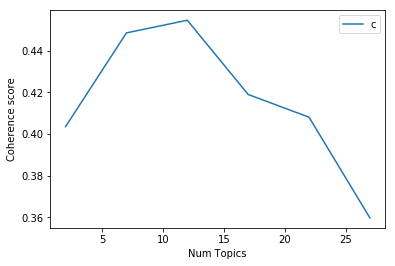

In [34]:
# Show graph
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4035
Num Topics = 7  has Coherence Value of 0.4486
Num Topics = 12  has Coherence Value of 0.4546
Num Topics = 17  has Coherence Value of 0.419
Num Topics = 22  has Coherence Value of 0.4081
Num Topics = 27  has Coherence Value of 0.3597


In [36]:
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
#pprint(optimal_model.print_topics(num_words=10))

### Define dominant topics in each sentence

In [37]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=texts):
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [44]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_nouns)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9365,"different, evaluate, text, range, context, explore, design, develop, structure, create","[Practise, refine, technical, expressive, skills, develop, proficiency, genre, style, specific, ..."
1,1,0.0,0.6547,"different, evaluate, text, range, context, explore, design, develop, structure, create","[Structure, dances, movement, motifs, choreographic, devices, form]"
2,2,0.0,0.9524,"different, evaluate, text, range, context, explore, design, develop, structure, create","[Explore, personal, movement, style, combining, elements, dance, improvisation, safe, dance, pra..."
3,3,0.0,0.5238,"different, evaluate, text, range, context, explore, design, develop, structure, create","[Manipulate, combinations, elements, dance, choreographic, devices, communicate, choreographic, ..."
4,4,0.0,0.9456,"different, evaluate, text, range, context, explore, design, develop, structure, create","[Perform, dances, genre, style, specific, techniques, expressive, skills, productions, elements,..."


In [39]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
#df_dominant_topics

### Frequency Distribution of Word Counts in Documents

In [40]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9653,"different, evaluate, text, range, context, explore, design, develop, structure, create","[Analyse, evaluate, use, methods, media, materials, design, elements, design, principles, visual..."
1,1.0,0.8340,"system, perspective, operation, health, apply, compare, rely, universe, magnet, coordinate","[animal, response, stimulus, coordinated, central, nervous, system, brain, spinal, cord, neurons..."
2,2.0,0.9459,"explain, include, influence, people, global, different, government, response, society, value","[Analyse, contemporary, examples, issues, relating, Australian, democracy, global, connections, ..."
3,3.0,0.8579,"scientific, technology, information, chemical, appropriate, include, datum, environment, time, c...","[Collect, record, relevant, geographical, data, information, ethical, protocols, reliable, usefu..."
4,4.0,0.9180,"place, cause, simple, living, nature, contribute, link, consequence, predict, country","[Causes, World, War, reasons, men, enlisted, war, women, contributed, war, effort]"
5,5.0,0.8688,"effect, significant, evaluate, change, pattern, task, analyse, activity, time, live","[Analyse, evaluate, broad, patterns, change, period, 1750–present]"
6,6.0,0.9060,"involve, relationship, energy, strategy, solve, reaction, investigate, component, process, transfer","[Investigate, use, range, learning, strategies, monitored, evaluated, directed, necessary]"
7,7.0,0.8933,"event, development, scientific, political, advance, atom, diversity, world, shape, examine","[Analyse, citizens, political, choices, shaped, including, influence, media]"


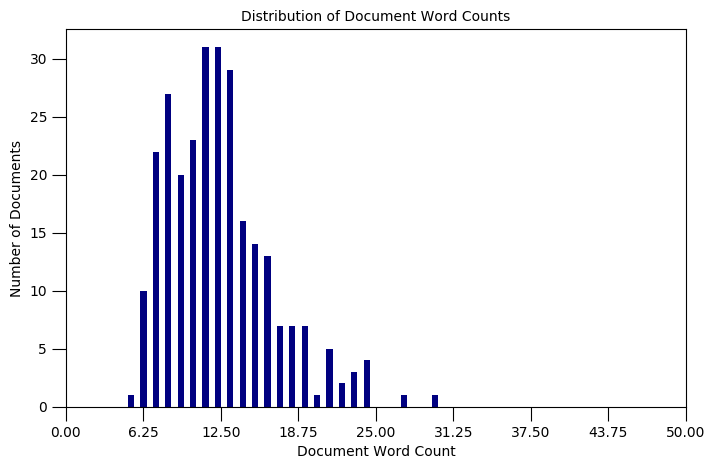

In [42]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

plt.figure(figsize=(8,5), dpi=100)
plt.hist(doc_lens, bins = 50, color='navy')
plt.gca().set(xlim=(0, 50), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=10)
plt.xticks(np.linspace(0,50,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=10))
plt.show()


### Word Clouds of Top N Keywords in Each Topic

In [45]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

/usr/local/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""


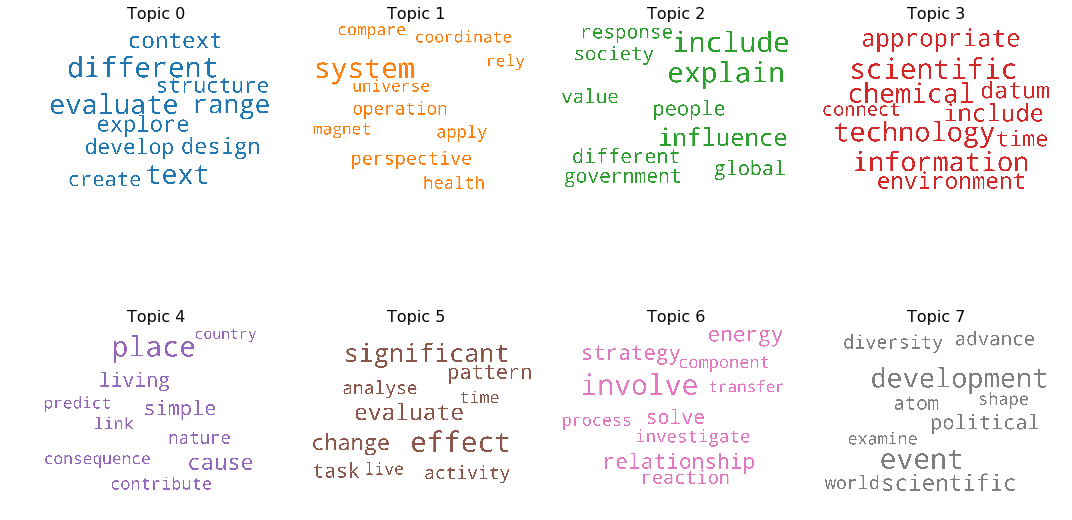

In [53]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 4, figsize=(15,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [55]:
plt.savefig('topic.png')

### t-SNE Clustering Chart

In [50]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

In [51]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points 
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 8
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=500, plot_height=400)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 265 samples in 0.004s...
[t-SNE] Computed neighbors for 265 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 265 / 265
[t-SNE] Mean sigma: 0.210723
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.961628
[t-SNE] KL divergence after 1000 iterations: 0.309469


Loading BokehJS ...